In [36]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
df = pd.read_csv('ltv_sp.csv')
df=df.sort_values('diff')
df['reg_week'] = pd.to_datetime(df['reg_week'])
df['student_share']=df['students']/df['cohort_size']

#df['pr_us']=df['amount'] / df['paid_user'] * 
#df=df.join(df.groupby('reg_week')['pr_us'].cumsum(), how='left', rsuffix='_cum')
df.tail()

,reg_week,diff,ltv,students,new_students,amount,cohort_size,paid_user,arpu,arppu,arppu_discounted,student_share
507,2015-04-01,1131,242760,3,0,5520,5,3,48552.000000,80920.000000,58362.230066,0.600000
734,2015-03-01,1133,251480,5,0,2760,6,5,41913.333333,50296.000000,32423.450175,0.833333
248,2015-05-01,1138,802760,9,0,5520,13,9,61750.769231,89195.555556,56942.817044,0.692308
735,2015-03-01,1147,254240,5,0,2760,6,5,42373.333333,50848.000000,32603.346600,0.833333
920,2015-03-01,1168,259760,5,0,5520,6,5,43293.333333,51952.000000,32955.829256,0.833333


In [38]:
# для штучных картинок (по одной когорте)

df2 = df[df['reg_week']=='2017-05-01'].groupby('diff').mean().reset_index()
df2['arppu_disc']=( ( df2['amount'] / df2['paid_user'] ) * (0.999023**df2['diff']) ).cumsum()

#dff2=dff[dff['month_reg']==201606]
df2.head()

,diff,ltv,students,new_students,amount,cohort_size,paid_user,arpu,arppu,arppu_discounted,student_share,arppu_disc
0,0,24840,2,2,24840,324,135,76.666667,184.000000,184.000000,0.006173,184.000000
1,1,148000,16,14,123160,324,135,456.790123,1096.296296,1095.404983,0.049383,1095.404983
2,2,270520,29,13,122520,324,135,834.938272,2003.851852,2001.188041,0.089506,2001.188041
3,3,317240,36,7,46720,324,135,979.135802,2349.925926,2346.248763,0.111111,2346.248763
4,4,358200,40,4,40960,324,135,1105.555556,2653.333333,2648.472191,0.123457,2648.472191


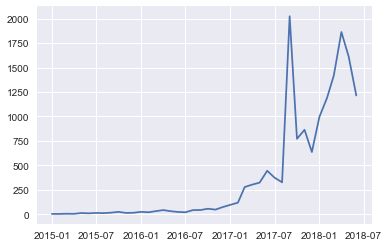

In [39]:
plt.plot(df.groupby('reg_week')['cohort_size'].max())

#df.groupby('reg_week')['cohort_size'].max()

In [40]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize

def expon(x, l1, l2 ):
    return l1 * np.exp(l2 * x)

def rational(x, p, q):
    """
    The general rational function description.
    p is a list with the polynomial coefficients in the numerator
    q is a list with the polynomial coefficients (except the first one)
    in the denominator
    The first coefficient of the denominator polynomial is fixed at 1.
    """
    return np.polyval(p, x) / np.polyval([1] + q, x)

def powe(x, l1, l2):
    return l1*(x*1.0)**l2

min_diff=60  # с каго дня фитим
max_diff=200 # по какой день

to_fit = df2

best_vals, covar = curve_fit(powe, to_fit[(to_fit['diff']<=max_diff) & (to_fit['diff']>=min_diff)]['diff'].values, 
                             to_fit[(to_fit['diff']<=max_diff) & (to_fit['diff']>=min_diff)]['arppu'].values)
                           # , p0=init_vals2)
#best_vals

#best_vals, covar = curve_fit(powe, df3[(df3['diff2']<=max_diff) & (df3['diff2']>=min_diff)]['diff2'].values, 
#                             df3[(df3['diff2']<=max_diff) & (df3['diff2']>=min_diff)]['arpu'].values)
#                           # , p0=init_vals2)
best_vals


array([ 510.5300577 ,    0.67877674])

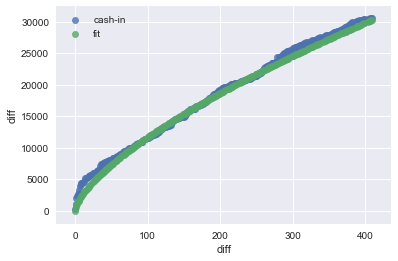

In [43]:
sns.regplot(x='diff', y='arppu', data=df2, fit_reg=False, label='cash-in')

#sns.regplot(df2['diff'], powe(df2['diff'], 1.94082176e+07, 3.69767431e-01), fit_reg=False)
sns.regplot(df2['diff'], powe(df2['diff'], *best_vals), fit_reg=False, label='fit')

#sns.regplot(x='diff2', y='pr_us_cum', data=dff2, fit_reg=False, label='GMV')
#sns.regplot(dff2['diff2'], powe(dff2['diff2'], *best_vals), fit_reg=False)
plt.legend()

In [50]:
#LTV и дисконтированием 30% в год = 9,77e-4 в день:
#best_vals[0]*best_vals[1]*(x**(best_vals[1]-1)) - это производная от best_vals[0] * x**best_vals[1]

import scipy.integrate as integrate
a, _ = integrate.quad(lambda x: best_vals[0]*best_vals[1]*(x**(best_vals[1]-1))*(0.999023**x), 0, np.inf)
a

44663.55055246376

In [45]:
min_diff=60
max_diff=120

#задаём когорты, на которые будем смотреть
df_t = df[(pd.to_datetime(df['reg_week'])>='2017-04-01') & (pd.to_datetime(df['reg_week'])<'2018-01-01')].sort_values('reg_week')

#l1 и l2 - фит первой части (линейной, первые покупки), p1 p2 - фит второй части
#l1 l2 я притащил, чтобы глянуть, как оно коррелирует с финальным ltv (плохо)
res=pd.DataFrame({'cohort': [pd.to_datetime('2020-01-01')], 
                  '1100day_fit': [0], 
                  'inf': 0,
                  'p1': 0, 
                  'p2': 0,
                  'l1': 0,
                  'l2': 0
 #                 ,'p11': 0,
 #                 'p21': 0
                 })

for month in df_t['reg_week'].unique():
    df2 = df_t[df_t['reg_week']==month].groupby('diff').mean().reset_index()
  #  df2['arpu_disc']=(df2['amount'] / df2['cohort_size'] * (0.999555**df2['diff']) ).cumsum()
    best_vals, covar = curve_fit(powe, df2[(df2['diff']<=max_diff) & (df2['diff']>=min_diff)]['diff'].values, 
                             df2[(df2['diff']<=max_diff) & (df2['diff']>=min_diff)]['arppu'].values)
 #                               p0 = init_vals)
 #   print(month, best_vals)
    a, _ = integrate.quad(lambda x: best_vals[0]*best_vals[1]*(x**(best_vals[1]-1))*(0.999023**x), 0, np.inf)
    
    best_vals_l, covar = curve_fit(powe, df2[(df2['diff']<min_diff)]['diff'].values, 
                             df2[(df2['diff']<min_diff)]['arppu'].values)
    res= res.append(pd.DataFrame({ 'cohort': [month],
                                   '1100day_fit': [powe(1100, *best_vals)],
                                  'inf': a,
                                  'error': ( df2['arppu'][-1:] - powe(df2['diff'], *best_vals)[-1:] ) / df2['arppu'][-1:],
                                  'p1':best_vals[0],
                                  'p2':best_vals[1],
                                  'l1': best_vals_l[0],
                                  'l2': best_vals_l[1]
        #                          ,'p11':best_vals[2],
        #                          'p21':best_vals[3]
                                 }))
    
res[1:].sort_values('cohort')
#res.sort_values('cohort').to_csv('forecast.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in power


,1100day_fit,cohort,error,inf,l1,l2,p1,p2
259,52611.757642,2017-04-01,0.033875,45042.764731,1516.035551,0.449327,717.828015,0.613226
322,44549.471859,2017-05-01,0.162927,38057.658523,1591.289107,0.416864,864.485600,0.562928
328,50902.170877,2017-06-01,0.096855,43522.005052,1965.412130,0.372828,821.922573,0.589173
292,60077.162874,2017-07-01,-0.074509,51554.324457,2021.376362,0.369444,663.836668,0.643340
246,48743.546709,2017-08-01,0.065672,41638.018830,3175.502447,0.296996,1289.094017,0.518720
245,56766.120699,2017-09-01,0.004684,48600.920231,2244.226543,0.346403,772.006995,0.613689
239,51465.384519,2017-10-01,-0.034742,44036.065152,2237.273301,0.336673,750.116152,0.603798
215,60851.767016,2017-11-01,0.003848,52217.457853,2374.838726,0.337140,673.983573,0.643003
185,52249.882623,2017-12-01,0.053054,44663.550552,1942.429375,0.379948,878.554672,0.583389


In [66]:
to_draw =  res[1:].sort_values('cohort')[['1100day_fit', 'cohort']]
to_draw.index = to_draw.cohort
to_draw.drop('cohort', inplace=True, axis=1)

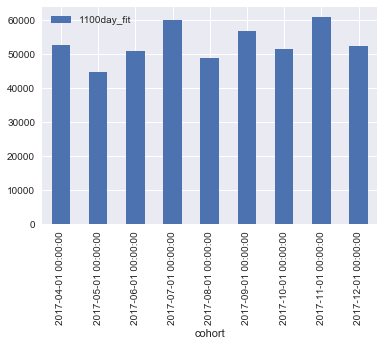

In [70]:
to_draw.plot(kind='bar')

,1100day_fit,cohort
cohort,,
2017-04-01,52611.757642,2017-04-01
2017-05-01,44549.471859,2017-05-01
2017-06-01,50902.170877,2017-06-01
2017-07-01,60077.162874,2017-07-01
2017-08-01,48743.546709,2017-08-01
2017-09-01,56766.120699,2017-09-01
2017-10-01,51465.384519,2017-10-01
2017-11-01,60851.767016,2017-11-01
2017-12-01,52249.882623,2017-12-01


In [46]:
res[1:].corr(method='spearman')


,1100day_fit,error,inf,l1,l2,p1,p2
1100day_fit,1.000000,-0.783333,1.000000,0.216667,-0.083333,-0.783333,0.916667
error,-0.783333,1.000000,-0.783333,-0.333333,0.383333,0.783333,-0.816667
inf,1.000000,-0.783333,1.000000,0.216667,-0.083333,-0.783333,0.916667
l1,0.216667,-0.333333,0.216667,1.000000,-0.950000,0.016667,0.116667
l2,-0.083333,0.383333,-0.083333,-0.950000,1.000000,-0.033333,-0.033333
p1,-0.783333,0.783333,-0.783333,0.016667,-0.033333,1.000000,-0.933333
p2,0.916667,-0.816667,0.916667,0.116667,-0.033333,-0.933333,1.000000


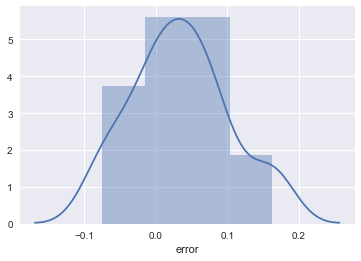

In [47]:
sns.distplot(res[1:]['error'])

In [48]:
# как коррелируют результаты за Х дней с более поздним LTV: через сколько дней можно говорить, куда двигается LTV

df_t = df[pd.to_datetime(df['reg_week'])<'2018-01-01']
bins = [0, 30, 40, 50, 60, 100, 150, 200, 500]
#bins= np.linspace(-1, 1800, 59)
df_corr=df_t.groupby([pd.cut(df_t['diff'], bins), 'reg_week'])['arppu'].max().reset_index().pivot(index='reg_week', columns='diff', values='arppu')
df_corr.columns = ['(0, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 100]', '(100, 150]', '(150, 200]', '(200, 500]']
#df_corr.columns = np.linspace(0, 7, 8)

df_corr.corr(method='spearman')

,"(0, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 100]","(100, 150]","(150, 200]","(200, 500]"
"(0, 30]",1.000000,0.948832,0.958065,0.939145,0.722969,0.673950,0.619557,0.519608
"(30, 40]",0.948832,1.000000,0.901538,0.883682,0.685428,0.646305,0.568144,0.390148
"(40, 50]",0.958065,0.901538,1.000000,0.965415,0.792214,0.812903,0.744758,0.629811
"(50, 60]",0.939145,0.883682,0.965415,1.000000,0.924615,0.896923,0.849231,0.727692
"(60, 100]",0.722969,0.685428,0.792214,0.924615,1.000000,0.914744,0.877340,0.709396
"(100, 150]",0.673950,0.646305,0.812903,0.896923,0.914744,1.000000,0.961497,0.860046
"(150, 200]",0.619557,0.568144,0.744758,0.849231,0.877340,0.961497,1.000000,0.841578
"(200, 500]",0.519608,0.390148,0.629811,0.727692,0.709396,0.860046,0.841578,1.000000


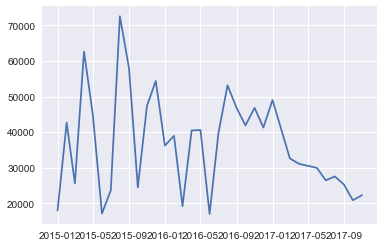

In [49]:
plt.plot(df_corr['(200, 500]'])